In [1]:
import tensorflow as tf
import numpy as np
import gym
import gym.spaces
import datetime as dt
import matplotlib.pyplot as plt

/home/martin/anaconda3/envs/pysc2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
env = gym.make("LunarLander-v2")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
class Agent:
    
    def __init__(self, name, input_layer, hsize, action_space_n, random_init=True):
        self.name = name
        self.hsize = hsize
        self.action_space_n = action_space_n
        with tf.variable_scope(name,reuse=False):
            self.input = input_layer
            self.h1 = tf.layers.dense(input_layer,hsize[0],activation=tf.nn.leaky_relu)
            self.h2 = tf.layers.dense(self.h1,hsize[1],activation=tf.nn.leaky_relu)
            self.out = tf.layers.dense(self.h2, action_space_n, activation=tf.nn.softmax)
            
    def zero(self):
        tr_vars = self.train_vars()
        for var in tr_vars:
            sess.run(tf.assign(var, tf.zeros_like(var)))
        
    def from_population(self, agents, weights):
        self.zero()
        weight = 1. / len(agents)
        train_vars = self.train_vars()
        for i in range(len(agents)):
        # for i in range(1):
            current_agent_vars = agents[i].train_vars()
            for j in range(len(current_agent_vars)):
            # for j in range(1):
                # print("train_vars[j]:\n", sess.run(train_vars[j]))
                # print("weights[i]:\n", weights[i])
                # print("current_agent_vars[j]:\n", sess.run(current_agent_vars[j]))
                # print("train_vars[j] + weights[i] * current_agent_vars[j]:\n", sess.run(train_vars[j] + weights[i] * current_agent_vars[j]))
                sess.run(tf.assign(train_vars[j], train_vars[j] + weights[i] * current_agent_vars[j]))
                # print("train_vars[j]:\n", sess.run(train_vars[j]))
        # print("from_population: ", sess.run(self.train_vars()[0])[0][0:5])
        return self
                
    def from_agent(self, agent, noise_dist = None):
        self_train_vars = self.train_vars()
        agent_train_vars = agent.train_vars()
        for i in range(len(self_train_vars)):
            if noise_dist is None:
                sess.run(tf.assign(self_train_vars[i], agent_train_vars[i]))
            else:
                sess.run(tf.assign(self_train_vars[i], agent_train_vars[i] + noise_dist.sample(agent_train_vars[i].shape)))
        return self
                
    def compute(self, observation):
        obs_np = np.array(observation).reshape((1, 8))
        return sess.run(self.out, feed_dict= {X : obs_np})
    
    def train_vars(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.name)
    
    def update(self, agent):
        pass

In [4]:
num_agents = 10
num_games_per_agent = 50
max_steps = 300
num_generations = 3
hsizes = [24, 24]
alpha = 0.03
sigma = 0.03

In [5]:
X = tf.placeholder(tf.float32,[None, env.observation_space.shape[0]])

In [6]:
normal_dist = dist = tf.distributions.Normal(loc=0., scale=sigma)

In [7]:
smith = Agent(name="Agent_Smith", input_layer=X, hsize=hsizes, action_space_n=env.action_space.n)
print(smith.train_vars())
agents = []
for i in range(num_agents):
    # agents.append(agent("agent/%d" % (i,), input_layer=X, hsize=hsizes, reuse=False, action_space_n=env.action_space.n))
    agents.append(Agent("agent/%d" % (i,), input_layer=X, hsize=hsizes, action_space_n=env.action_space.n))

[<tf.Variable 'Agent_Smith/dense/kernel:0' shape=(8, 24) dtype=float32_ref>, <tf.Variable 'Agent_Smith/dense/bias:0' shape=(24,) dtype=float32_ref>, <tf.Variable 'Agent_Smith/dense_1/kernel:0' shape=(24, 24) dtype=float32_ref>, <tf.Variable 'Agent_Smith/dense_1/bias:0' shape=(24,) dtype=float32_ref>, <tf.Variable 'Agent_Smith/dense_2/kernel:0' shape=(24, 4) dtype=float32_ref>, <tf.Variable 'Agent_Smith/dense_2/bias:0' shape=(4,) dtype=float32_ref>]


In [8]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

In [9]:
#for i in range(num_agents):
#    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "agent/%d" % (i,))
#    print(sess.run(train_vars))
#    print("======================")

In [10]:
def play(env, agent, num_games, max_steps, render):
    rewards = np.zeros([num_games])
    actions = [_ for _ in range(env.action_space.n)]
    for g in range(num_games):
        obs = env.reset()
        #print(obs)
        reward_accum = 0
        for i in range(max_steps):
            # obs_np = np.array(obs).reshape((1, 8))
            # action_probabilities = sess.run(agent, feed_dict= {X : obs_np})
            action_probabilities = agent.compute(obs)[0]
            
            #obs, r, done, info = env.step(env.action_space.sample())
            action = np.random.choice(a=actions, p=action_probabilities)
            obs, r, done, info = env.step(action)
            if render == True:
                env.render()
            reward_accum += r
            if done == True:
                break
        rewards[g] = reward_accum
    return rewards.sum()

In [11]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [12]:
generation = 1
max_rewards = []
avg_rewards = []
training_history = {}

In [53]:
start = dt.datetime.now()
print("training started: " + str(start))
# for generation in range(num_generations):
stop_requested = False
while(stop_requested == False):
    rewards_np = np.zeros([num_agents])
    for i in range(num_agents):
        rewards_np[i] = play(env=env, agent=agents[i], num_games=num_games_per_agent, max_steps=max_steps, render=False)
    print(generation, rewards_np.max(), rewards_np.mean())
    max_rewards.append(rewards_np.max())
    avg_rewards.append(rewards_np.mean())
    ind = np.argmax(rewards_np)
    #weights = np.zeros((num_agents, ))
    # weights[ind] = 1.
    # smith.from_population(agents=agents, weights = weights  )
    smith.from_population(agents=(agents[ind],), weights = (1, )  )
    for i in range(num_agents):
        # if i == 0:
        #    print(sess.run(agents[i].train_vars()[0])[0][0:5])
        agents[i].from_agent(agent=smith, noise_dist=normal_dist)
        
    with open("/home/martin/1.ctl") as f:
        cmd = f.readline()
        if cmd.find("RUN") < 0:
            stop_requested = True
    
    if generation % 50 == 0:
        training_history[generation] = Agent(name="Generation_%d" % generation, \
                                             input_layer=X, \
                                             hsize=hsizes, \
                                             action_space_n=env.action_space.n).from_agent(smith)
        
    generation += 1

end = dt.datetime.now()
print("training ended: " + str(end))
print("total training time: " + str(end - start))
print("average generation training time: ", str((end - start).total_seconds() / len(max_rewards)) )

training started: 2018-09-14 10:00:23.476416
162 1525.847323820988 484.1843789958798
163 1090.2132593401989 -106.00647168345458
164 1755.8810056900527 665.6192196740247
165 1800.547163707849 1141.4584385475462
166 1602.6291815641875 1100.7865650621725
167 1602.729318927692 594.1721171694817
168 1711.632927723274 473.1211727818485
169 1904.5159612712923 1356.077264144207
170 2149.203957473132 990.3788808855967
171 2574.5683638438027 968.7772268946549
172 2045.115289429682 1430.79150185937
173 1970.0032585766367 1232.482750941615
174 2058.2217787549325 1363.950107022513
175 2311.2927988749225 1665.4978318490732
176 1903.4681353680494 1494.2567390137428
177 2500.5360469423867 1858.0925336626292
178 2141.2152541463806 1509.451461244005
179 2339.312254320599 1660.7527094634006
180 2089.9515082520456 1584.7019710898417
181 2026.4307382396328 1567.0668421958467
182 2423.4326354397 1480.1329746665838
183 2250.9209068114656 1912.7620567894742
184 2590.009242776701 2019.9440842677927
185 2504.86

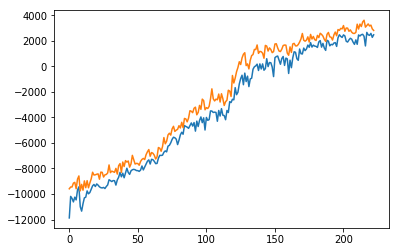

In [54]:
plt.plot(range(len(avg_rewards)), avg_rewards)
plt.plot(range(len(max_rewards)), max_rewards)
plt.show()

accum reward:  32.21551361179274


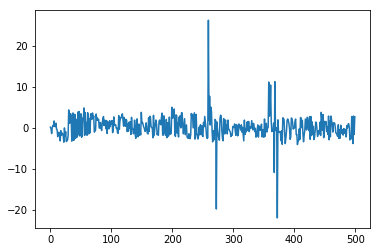

In [80]:
obs = env.reset()
actions = [_ for _ in range(env.action_space.n)]
rewards = []

for i in range(500):
    action_probabilities = smith.compute(obs)[0]
            
    # obs, r, done, info = env.step(env.action_space.sample())
    # action = np.random.choice(a=actions, p=action_probabilities)
    # o, r, done, info = env.step(env.action_space.sample())
    
    action = np.random.choice(a=actions, p=action_probabilities)
    obs, r, done, info = env.step(action)
    rewards.append(r)
    env.render()
    #print(obs, r, done, info)
    if done:
        break

print ("accum reward: ", np.array(rewards).sum())
plt.plot(range(len(rewards)), rewards)
plt.show()

In [52]:
training_history

{10: <__main__.Agent at 0x7f981c0e4ef0>,
 20: <__main__.Agent at 0x7f9816320a58>,
 30: <__main__.Agent at 0x7f980fb83668>,
 40: <__main__.Agent at 0x7f98812515c0>,
 50: <__main__.Agent at 0x7f9800c0d8d0>,
 100: <__main__.Agent at 0x7f97df561b70>,
 150: <__main__.Agent at 0x7f97bf29bc50>}